# OSE-Summer School 2019
## Wk5: Computation, Conditioning and Stability

In [1]:
import numpy as np
import sympy as sy
import scipy.linalg as la
from matplotlib import pyplot as plt
from numpy import linalg

### Problem 1

In [2]:
def condition_num(A):
    
    singular_values = la.svdvals(A)
    σmax = np.max(singular_values)
    σmin = np.min(singular_values)
    if σmin == 0:
        cond_num = np.inf
    else:
        cond_num = σmax / σmin
    
    return cond_num

In [3]:
# check by comparing it to np.linglg.cond
A = np.array([[1,1], [1,1+1e-10]])
condition_num(A) - np.linalg.cond(A)

0.0

In [4]:
# check for an orthonormal matrix
Q, R = la.qr(A)  # Q is orthogonal and R is upper triangular
print("condition_num of Q = %4.4f" % condition_num(Q))

condition_num of Q = 1.0000


In [5]:
# check for a singular matrix
B = np.array([[1,1], [0,0]])
condition_num(B)

inf

### Problem 2

In [6]:
def wilkinson(n, μ, σ):
    
    w_roots = np.sort(np.arange(1, 21))
    
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    
    abs_cond_num = np.zeros((n))
    rel_cond_num = np.zeros((n))
    
    fig = plt.subplots(1,1,figsize=[11,7])
    plt.subplot(111)
    plt.scatter(w_roots.real, w_roots.imag, s=80)
    
    for i in range(n):
        r = np.random.normal(μ, σ, 21)
        new_coeffs = np.multiply(w_coeffs, r)
        new_roots = np.roots(np.poly1d(new_coeffs))
        new_roots = np.sort(new_roots)
        
        plt.scatter(new_roots.real, new_roots.imag, \
                    marker=',', color='Black', s=1)
        abs_cond_num[i] = la.norm(new_roots - w_roots, np.inf) / la.norm(w_coeffs - new_coeffs, np.inf)
        rel_cond_num[i] = abs_cond_num[i] * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)

    avg_abs_cond_num = np.mean(abs_cond_num)
    avg_rel_cond_num = np.mean(rel_cond_num)
    
    plt.xlabel("Real Axis", fontsize=12)
    plt.ylabel("Imaginary Axis", fontsize=12)
    plt.legend(["original", "perturbed"], fontsize=12, loc=2)
    
    print("the average computed absolute condition number: %6.5e" % avg_abs_cond_num)
    print("the average computed relative condition number: %6.5e" % avg_rel_cond_num)

    return (avg_abs_cond_num, avg_rel_cond_num)

the average computed absolute condition number: 3.67955e-09
the average computed relative condition number: 2.53958e+09


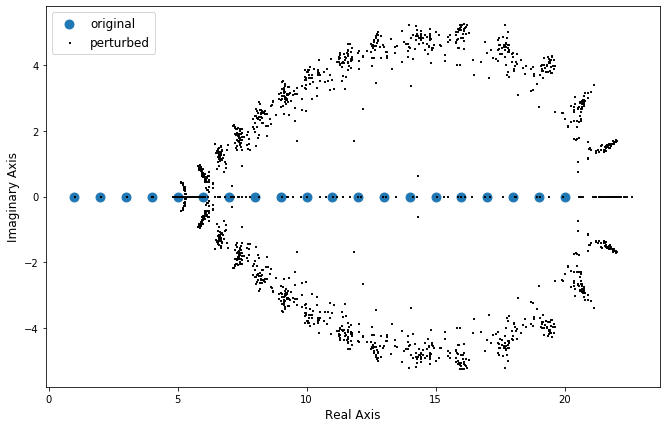

In [7]:
n, μ, σ = 100, 1, 1e-10
avg_abs_cond_num, avg_rel_cond_num = wilkinson(n, μ, σ)

### Problem 3

In [8]:
def condition_num_q3(A):
    
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    eigvals_A = la.eigvals(A)
    eigvals_A_H = la.eigvals(A+H)
    abs_cond_num = la.norm(eigvals_A - eigvals_A_H, 2) / la.norm(H, 2)
    rel_cond_num = abs_cond_num * la.norm(A, 2) / la.norm(eigvals_A, 2)
    
    return (abs_cond_num, rel_cond_num)

In [9]:
# test
A = np.array([[1,1], [1,1]])
abs_cond_num, rel_cond_num = condition_num_q3(A)
print("the absolute condition number = %6.3e" % abs_cond_num)
print("the relative condition number = %6.3e" % rel_cond_num)

the absolute condition number = 3.741e-01
the relative condition number = 3.741e-01


### Problem 4

In [10]:
def plot_rel_cond_num(xmin, xmax, ymin, ymax, res: int):
    
    xgrid = np.linspace(xmin, xmax, res)
    ygrid = np.linspace(ymin, ymax, res)
    rel_cond_num = np.zeros((res, res))
    
    for ix in range(res):
        x = xgrid[ix]
        for iy in range(res):
            y = ygrid[iy]
            A = np.array([[1, x], [y, 1]])
            rel_cond_num[ix,iy] = condition_num_q3(A)[1]
    
    plt.pcolormesh(xgrid, ygrid, rel_cond_num, cmap='gray_r')
    plt.colorbar()
    
    return rel_cond_num

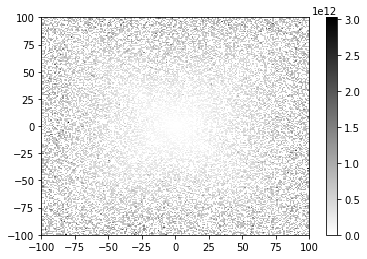

In [11]:
rel_cond_num = plot_rel_cond_num(-100, 100, -100, 100, res=200)

### Problem 5

In [12]:
# import data
xk, yk = np.load("stability_data.npy").T

In [13]:
def solve_normal_eq(n: int, nx: int):
    
    A = np.vander(xk, n+1)
    b = yk
    
    # normal equations
    coef_NE = la.inv(A.T @ A) @ A.T @ b
    
    # QR solver
    Q, R = la.qr(A, mode='economic')
    coef_QR = la.solve_triangular(R, Q.T @ b)
    
    # plot
    xgrid = np.linspace(np.amin(xk), np.amax(xk), nx)
    plt.scatter(xk, yk, s=4, color='Black')
    plt.plot(xgrid, np.polyval(coef_NE, xgrid), label='Normal Equations')
    plt.plot(xgrid, np.polyval(coef_QR, xgrid), label='QR Solver')
    plt.legend(loc=2)
    plt.title("n=%d" % n)
    plt.xlabel("x")
    plt.ylabel("y")
    
    forward_error_NE = la.norm(A @ coef_NE - yk, 2)
    forward_error_QR = la.norm(A @ coef_QR - yk, 2)
    
    return (forward_error_NE, forward_error_QR)

the forward error (Normal Equations) = 8.201e+01
the forward error (QR Solver)        = 4.520e+00


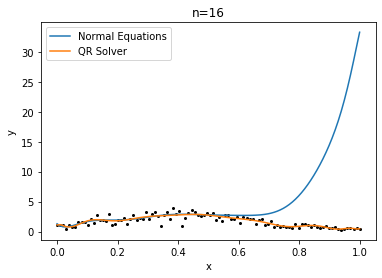

In [14]:
f_error_NE, f_error_QR = solve_normal_eq(16, 100)

print("the forward error (Normal Equations) = %6.3e" % f_error_NE)
print("the forward error (QR Solver)        = %6.3e" % f_error_QR)

### Problem 6

Text(0.5, 1.0, 'The relative forward error (log scale)')

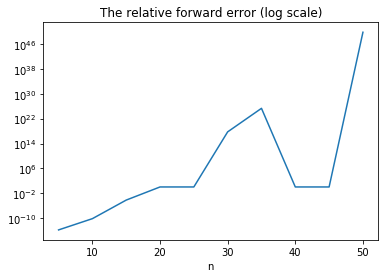

In [15]:
def check_stability(n: int):
    
    x = sy.symbols('x')
    eq = (x**n) * sy.exp(x-1)
    
    I_inte = float(sy.integrate(eq, (x, 0, 1)))
    I_comp = float(((-1)**n) * sy.subfactorial(n) + ((-1)**(n+1)) * sy.factorial(n) / np.exp(1))
    foward_error = (np.abs(I_inte - I_comp) / np.abs(I_inte))
    
    return foward_error

ngrid = np.arange(1,11)*5
error = np.zeros(len(ngrid))

for i, n in enumerate(ngrid):
    error[i] = check_stability(n)
    
plt.plot(ngrid, error)
plt.yscale('log')
plt.xlabel('n')
plt.title('The relative forward error (log scale)')

### End